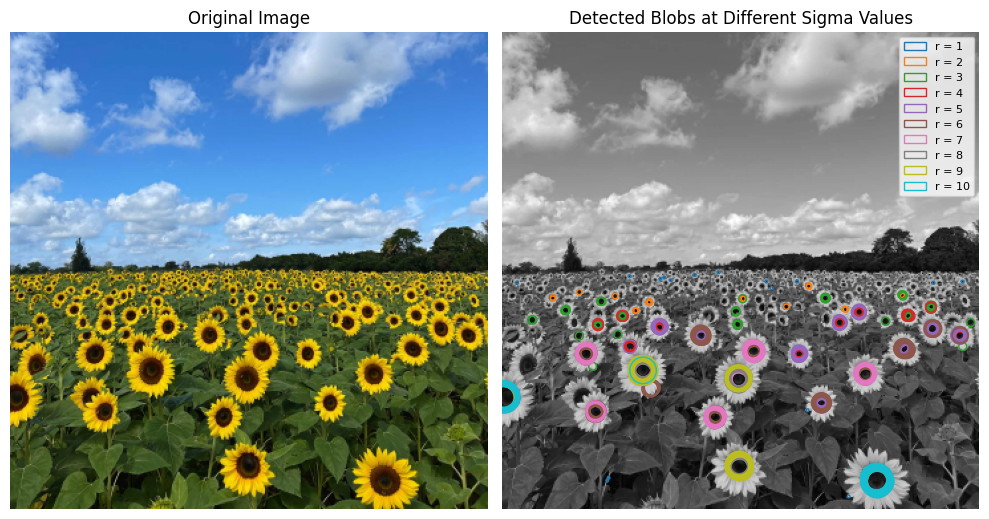

In [27]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Function to compute Laplacian of Gaussian (LoG) kernel
def laplace_of_gaussian(sigma):
    hw = round(3 * sigma)  # Half width of kernel based on sigma
    X, Y = np.meshgrid(np.arange(-hw, hw + 1, 1), np.arange(-hw, hw + 1, 1))  # Create meshgrid
    log = ((X**2 + Y**2) / (2 * sigma**2) - 1) * np.exp(-(X**2 + Y**2) / (2 * sigma**2)) / (np.pi * sigma**4)
    return log

# Function to detect maxima in the image using the Laplacian of Gaussian response
def detect_max(img_log, sigma, threshold=0.09):
    (h, w) = img_log.shape
    coordinates = []
    k = 1  # Offset for local neighborhood
    for i in range(k, h - k):
        for j in range(k, w - k):
            slice_img = img_log[i - k:i + k + 1, j - k:j + k + 1]
            result = np.max(slice_img)  # Finding maximum in local neighborhood
            if result >= threshold:
                x, y = np.unravel_index(slice_img.argmax(), slice_img.shape)
                coordinates.append((i + x - k, j + y - k))  # Append coordinates
    return set(coordinates)

# Load image and convert to grayscale
img1 = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
img1_gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY) / 255.0

# Create figure to display results
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

# Display original image
axes[0].imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
axes[0].set_title("Original Image")
axes[0].axis('off')

# Display grayscale image with detected blobs
ax = axes[1]
ax.imshow(img1_gray, cmap='gray')
ax.set_title("Detected Blobs at Different Sigma Values")
ax.axis('off')

# Define colors for different sigma values
colors = list(mcolors.TABLEAU_COLORS)
patches, labels = [], []

# Loop over multiple sigma values for blob detection
for r in range(1, 11):
    sigma = r / 1.414  # Scale sigma
    LOG = sigma**2 * laplace_of_gaussian(sigma)  # Compute LoG filter
    img1_log = np.square(cv.filter2D(img1_gray, -1, LOG))  # Apply filter and square result

    coordinates = detect_max(img1_log, sigma)  # Detect local maxima in LoG response

    # Plot detected blobs as circles
    for x, y in coordinates:
        c = plt.Circle((y, x), sigma * 1.414, color=colors[r - 1], linewidth=1, fill=False)
        ax.add_patch(c)

    # Store legend patches and labels
    patches.append(c)
    labels.append(f'r = {r}')

# Add legend to the plot
ax.legend(patches, labels, loc='best', fontsize=8)
ax.set_xlim(0, img1.shape[1])

plt.tight_layout()
plt.show()

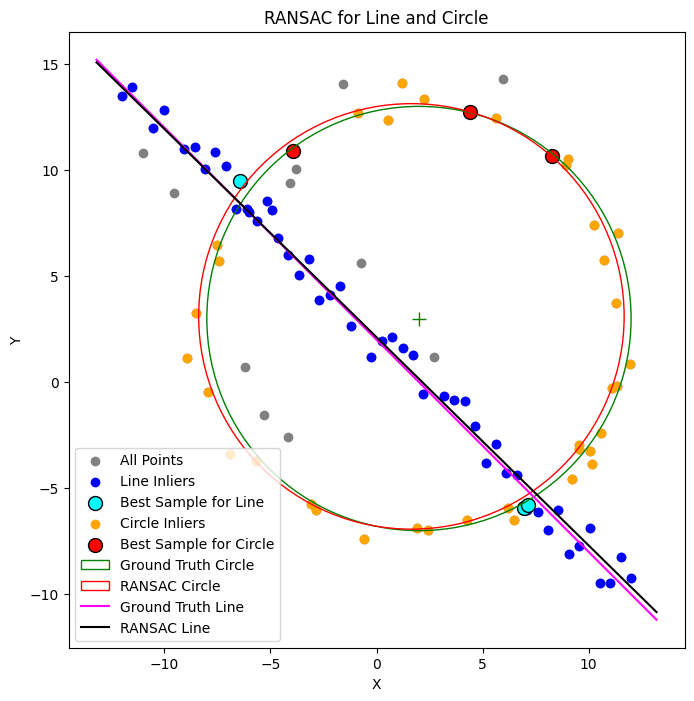

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# Generate the noisy points (same as before)
N = 100
half_n = N // 2
r = 10  # Radius of the circle
x0_gt, y0_gt = 2, 3  # Ground truth center of the circle
s = r / 16  # Noise level for the circle points
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)

# Circle points
x_circ, y_circ = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x_circ.reshape(half_n, 1), y_circ.reshape(half_n, 1)))

# Line points
s_line = 1.0  # Noise level for the line points
m, b = -1, 2  # Slope and intercept of the line
x_line = np.linspace(-12, 12, half_n)
y_line = m * x_line + b + s_line * np.random.randn(half_n)
X_line = np.hstack((x_line.reshape(half_n, 1), y_line.reshape(half_n, 1)))

# Combine circle and line points
X = np.vstack((X_circ, X_line))

# RANSAC for Line Fitting
def fit_line_ransac(X, num_trials=100, threshold=1.0):
    best_line = None
    max_inliers = 0
    best_inliers = None
    
    for _ in range(num_trials):
        # Randomly sample 2 points for line fitting
        sample_idx = np.random.choice(len(X), 2, replace=False)
        sample_points = X[sample_idx]
        
        # Fit line to these 2 points: ax + by + d = 0
        (x1, y1), (x2, y2) = sample_points
        if x2 == x1:
            continue  # Avoid divide by zero
        a = (y2 - y1) / (x2 - x1)
        b = -1
        d = y1 - a * x1
        
        # Compute residuals (distance of each point from the line)
        residuals = np.abs(a * X[:, 0] + b * X[:, 1] + d) / np.sqrt(a**2 + b**2)
        inliers = residuals < threshold
        num_inliers = np.sum(inliers)
        
        # Update best line if it has more inliers
        if num_inliers > max_inliers:
            best_line = (a, b, d)
            max_inliers = num_inliers
            best_inliers = inliers
    
    return best_line, best_inliers

# Perform RANSAC for line fitting
best_line, line_inliers = fit_line_ransac(X, num_trials=100, threshold=1.0)
line_outliers = np.logical_not(line_inliers)

# Best sample for line (random subset of 3 inliers)
best_sample_line = X[line_inliers][:3]

# Subtract line inliers from the dataset for circle fitting
X_remnant = X[line_outliers]

# Circle fitting function using least squares
def circle_residuals(params, points):
    x0, y0, r = params
    residuals = np.sqrt((points[:, 0] - x0) ** 2 + (points[:, 1] - y0) ** 2) - r
    return residuals

# RANSAC for circle fitting (random subsets of 3 points and fit a circle)
def ransac_circle(X, num_trials=100, error_threshold=1.0):
    best_circle = None
    max_inliers = 0
    best_inliers = None
    
    for _ in range(num_trials):
        # Randomly sample 3 points
        sample_idx = np.random.choice(len(X), 3, replace=False)
        sample_points = X[sample_idx]
        
        # Fit circle to these 3 points
        x0_init = np.mean(sample_points[:, 0])
        y0_init = np.mean(sample_points[:, 1])
        r_init = np.mean(np.sqrt((sample_points[:, 0] - x0_init) ** 2 + (sample_points[:, 1] - y0_init) ** 2))
        
        # Use least_squares to fit the circle
        result = least_squares(circle_residuals, [x0_init, y0_init, r_init], args=(sample_points,))
        x0, y0, r = result.x
        
        # Compute residuals for all points
        residuals = np.abs(np.sqrt((X[:, 0] - x0) ** 2 + (X[:, 1] - y0) ** 2) - r)
        inliers = residuals < error_threshold
        num_inliers = np.sum(inliers)
        
        # Update best circle if it has more inliers
        if num_inliers > max_inliers:
            best_circle = (x0, y0, r)
            max_inliers = num_inliers
            best_inliers = inliers
    
    return best_circle, best_inliers

# Perform RANSAC for circle fitting on the remnant points
best_circle, circle_inliers = ransac_circle(X_remnant)
best_sample_circle = X_remnant[circle_inliers][:3]

# Plot everything
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# All points
ax.scatter(X[:, 0], X[:, 1], label='All Points', color='gray')

# Line inliers
ax.scatter(X[line_inliers, 0], X[line_inliers, 1], label='Line Inliers', color='blue')

# Best sample for line
ax.scatter(best_sample_line[:, 0], best_sample_line[:, 1], label='Best Sample for Line', color='cyan', edgecolor='black', s=100)

# Circle inliers
ax.scatter(X_remnant[circle_inliers, 0], X_remnant[circle_inliers, 1], label='Circle Inliers', color='orange')

# Best sample for circle
ax.scatter(best_sample_circle[:, 0], best_sample_circle[:, 1], label='Best Sample for Circle', color='red', edgecolor='black', s=100)

# Ground truth circle
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='green', fill=False, label='Ground Truth Circle')
ax.add_patch(circle_gt)
ax.plot([x0_gt], [y0_gt], '+', color='green', markersize=10)

# RANSAC circle
x0_ransac, y0_ransac, r_ransac = best_circle
circle_ransac = plt.Circle((x0_ransac, y0_ransac), r_ransac, color='red', fill=False, label='RANSAC Circle')
ax.add_patch(circle_ransac)

# Ground truth line
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='magenta', label='Ground Truth Line')

# RANSAC line
a, b_ransac, d_ransac = best_line
y_ransac = -(a * x_ + d_ransac) / b_ransac
plt.plot(x_, y_ransac, color='black', label='RANSAC Line')

# Finalize plot
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('RANSAC for Line and Circle')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

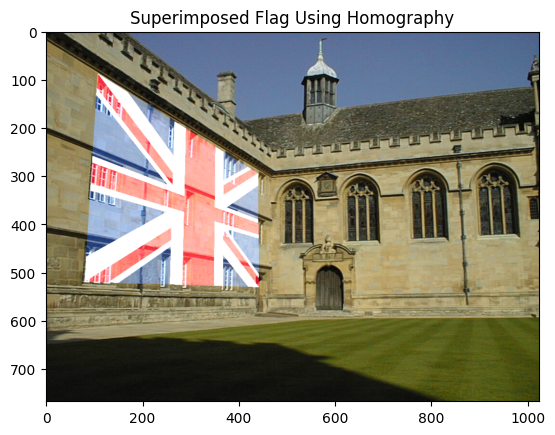

In [26]:
import cv2
img = cv2.imread('flag.png')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
background = cv2.imread('005.jpg')
background = cv2.cvtColor(background,cv2.COLOR_BGR2RGB)

rows,cols,ch = background.shape

pts1 = np.float32([[0, 0], [cols-1, 0], [cols-1, rows-1], [0, rows-1]]) # cola coords 
pts2 = np.float32([[80, 520], [95, 280], [400, 388],[400, 530]]) # stadium tile coords

M = cv2.getPerspectiveTransform(pts1,pts2)    
dst = cv2.warpPerspective(img,M,(cols,rows))

overlay = cv2.add(background, dst)
# Display the result
plt.imshow(overlay)
plt.title("Superimposed Flag Using Homography")
plt.show()

(np.float64(-0.5), np.float64(1599.5), np.float64(639.5), np.float64(-0.5))

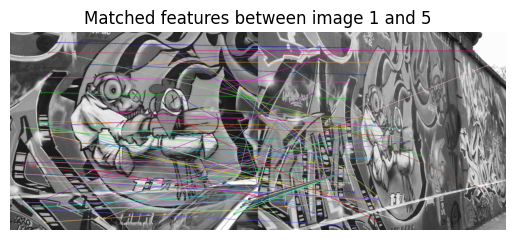

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from skimage.feature import peak_local_max
from skimage import transform


img1 = cv2.imread("graf/img1.ppm")
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

img5 = cv2.imread("graf/img5.ppm")
img5 = cv2.cvtColor(img5, cv2.COLOR_BGR2RGB)

# Feature matching with SIFT
img1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
img5_gray = cv2.cvtColor(img5, cv2.COLOR_RGB2GRAY)

# Identify key points of each image
sift = cv2.SIFT_create(nOctaveLayers = 3,contrastThreshold = 0.09, edgeThreshold = 25, sigma = 1) 

kp1, des1 = sift.detectAndCompute(img1_gray, None)
kp5, des5 = sift.detectAndCompute(img5_gray, None)

bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des5, k=2)  # Find k best matches
# Apply ratio test
good_matches = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good_matches.append(m)

plt.figure()
matched_img = cv2.drawMatches(img1_gray, kp1, img5_gray, kp5, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(matched_img)
plt.title("Matched features between image 1 and 5")
plt.axis('off')

#features = SIFT_features(img1, img5, plot = True)

In [10]:
# Extract keypoint coordinates from the good matches
src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp5[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# Compute homography using RANSAC
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# Homography given in the dataset (for comparison)
H_dataset = np.array([[6.2544644e-01 ,  5.7759174e-02 ,  2.2201217e+02],
   [2.2240536e-01 ,  1.1652147e+00 , -2.5605611e+01],
   [4.9212545e-04 , -3.6542424e-05  , 1.0000000e+00]])  # Add the homography matrix from the dataset

# Compare with the given homography matrix
difference = np.abs(H - H_dataset)

print("Difference between computed and dataset homography:\n", difference)

Difference between computed and dataset homography:
 [[1.00312379e+00 3.90644590e-01 5.23566280e+01]
 [8.46964554e-01 1.71446008e+00 4.78859201e+02]
 [1.86437254e-03 1.17820363e-03 0.00000000e+00]]


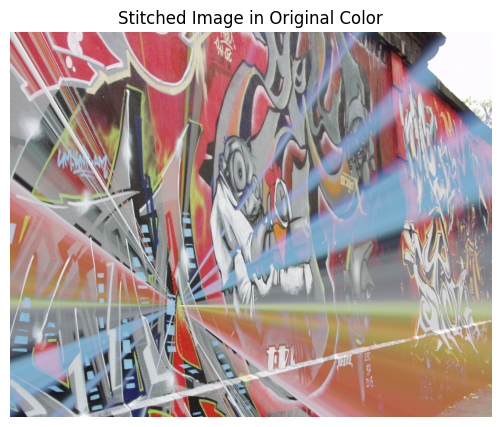

In [11]:
# Assuming H (homography matrix) is already computed
# Get the shape of img5 for the output canvas size
h5, w5, _ = img5.shape  # Color image has 3 channels

# Warp img1 to the perspective of img5 using the computed homography
warped_img1 = cv2.warpPerspective(img1, H, (w5, h5))

# Stitch the two images by blending (pixel-wise maximum to overlay)
stitched_img = np.maximum(warped_img1, img5)

# Plot the stitched image in color using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(stitched_img)
plt.title("Stitched Image in Original Color")
plt.axis('off')  # Hide axes
plt.show()